# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки math
import math
# Импорт библиотеки seaborn
import seaborn as sns
# Импорт библиотеки re
import re
# Импорт библиотеки time
import time
# Импорт библиотеки sklearn и необходимых компонентов
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
</font> 

In [2]:
# Загрузка таблицы в память переменной df типа dataframe
df = pd.read_csv('/datasets/autos.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print('\033[1m\033[43m {}'.format('----- Просмотр общей информации о dataframe -----'),'\033[0m')
df.info()
print('\033[1m\033[43m {}'.format('----- Информация о заголовках полей dataframe -----'),'\033[0m')
print(df.columns)
print('\033[1m\033[43m {}'.format('----- Информация о типах полей dataframe -----'),'\033[0m')
print(df.dtypes)
print('\033[1m\033[43m {}'.format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),'\033[0m')
display(df.head())
print('Количество явных дубликатов', df.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen        

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Количество явных дубликатов 4


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Присутствует необходимость в редактировании заголовков, названия представлены в формате "Верблюжий регистр", рекомендуется отобразить в условно общепринятом формате 'Змеиный регистр'
2. Выявлены явные дубликаты, необходимо удаление повторяющихся объектов
3. Тип данных некоторых числовых полей желательно преобразовать для уменьшения требуемого объема памяти хранения данных, также необходимо конвертировать время в соответствующий тип
4. Обнаружены пропуски во многих столбцах. Желательно рассмотреть закономерность их проявления и заполнить подходящими для соответствующих записей значениями, оставить текущие или, в противном случае, удалить, так как для обработки данных с использованием алгоритмов машинного обучения необходимо отсутствие пропущенных значений в используемых выборках
5. В данных таблицы возможны некорректные значения, необходимо детально рассмотреть параметры каждого столбца
</font> 

In [3]:
col = []
for i in range(len(df.columns)):
    col.append(re.sub(r'(?<!^)(?=[A-Z])', '_', df.columns[i]).lower())
df.columns = col
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<font color='DarkBlue'> 
📌 Заголовки полей приведены к общепринятому формату <br>
📌 Необходимо удалить явные дубликаты и преобразовать типы полей, содержащих значения времени <br>
</font> 

In [4]:
df = df.drop_duplicates().reset_index(drop=True)
df['date_crawled'] = pd.to_datetime(df['date_crawled'],format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'],format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'],format='%Y-%m-%d %H:%M:%S')

<font color='DarkBlue'> 
📌 Теперь необходимо детально рассмотреть параметры каждого столбца и построить гистограммы распределения <br>
</font> 

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,354365,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365,354365.0,354365.000000,354365
mean,2016-03-21 12:58:09.520460544,4416.679830,2004.234481,110.093816,128211.363989,5.714650,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.176349,90.228466,189.851330,37905.083858,3.726432,NaN,0.0,25783.100078,NaN


,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,316875,334532,334660,321470,354365,283211
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268249,29232,216349,77012,247158


-----
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64
-----
manual    268249
auto       66283
Name: gearbox, dtype: int64
-----
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64
-----
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64
-----
volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat 

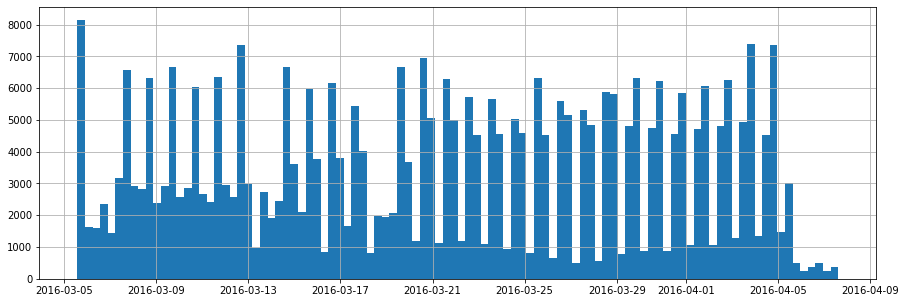

price


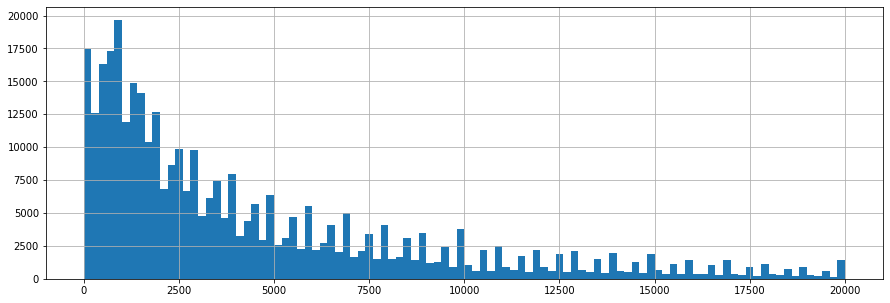

vehicle_type


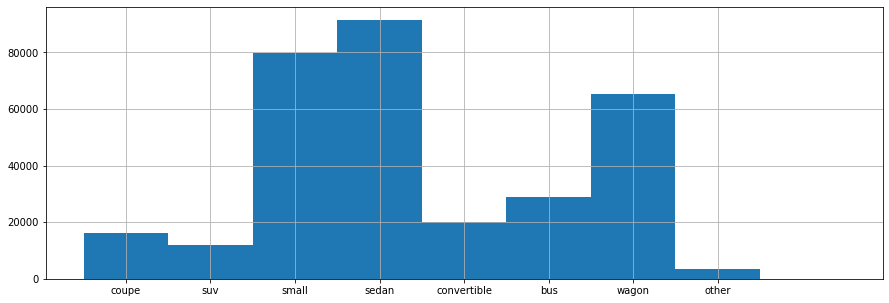

registration_year


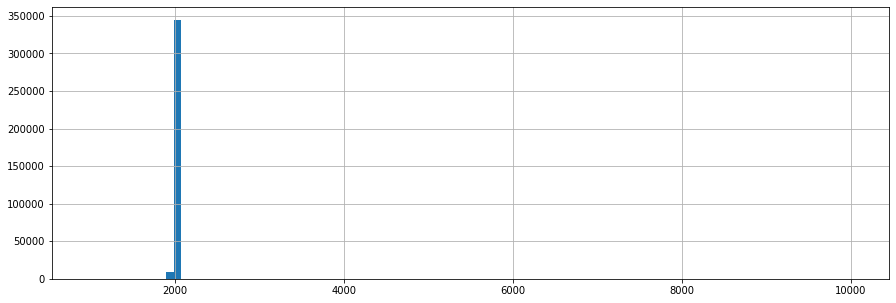

gearbox


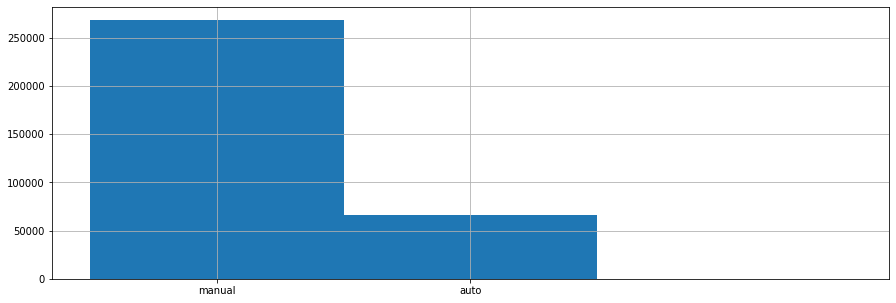

power


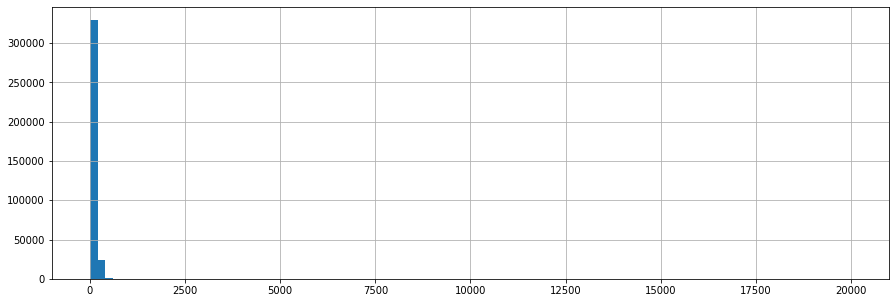

kilometer


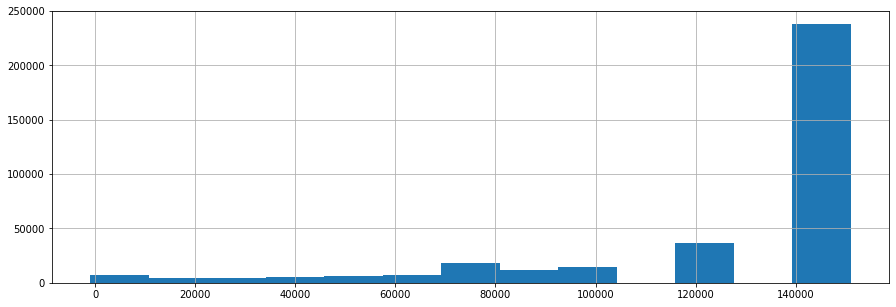

registration_month


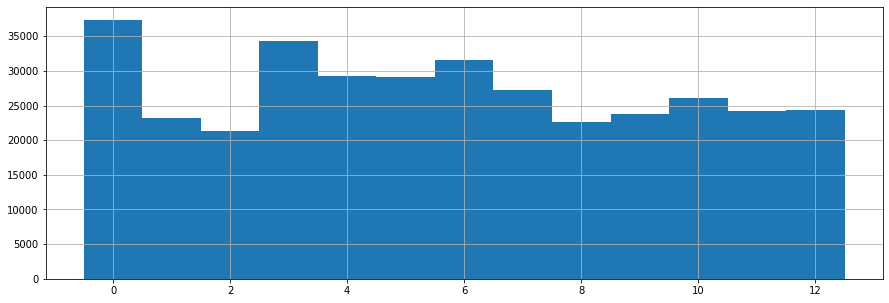

fuel_type


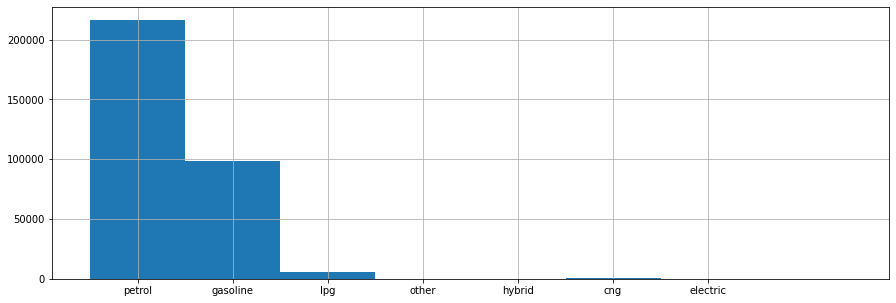

brand


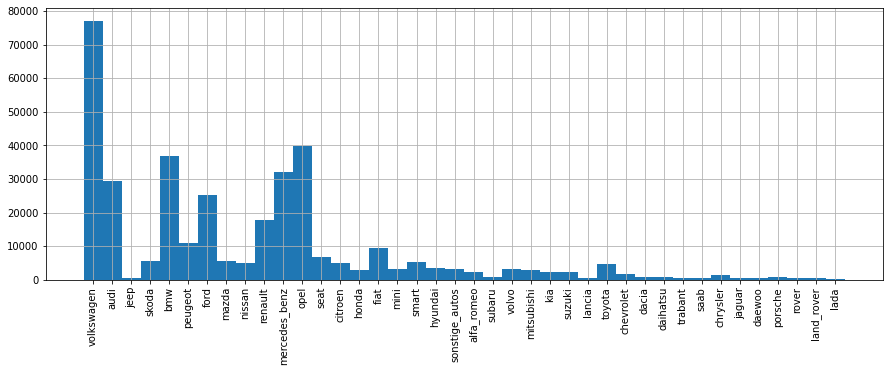

not_repaired


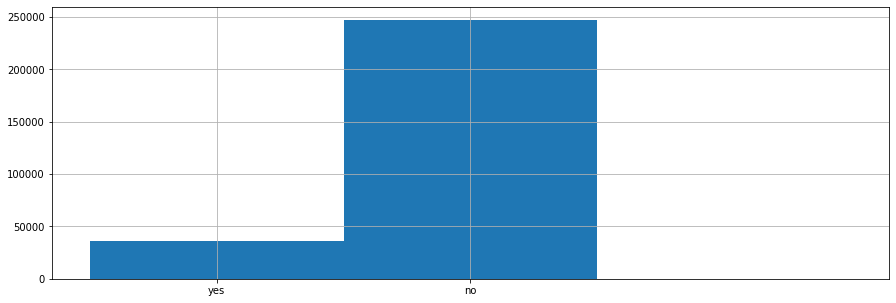

date_created


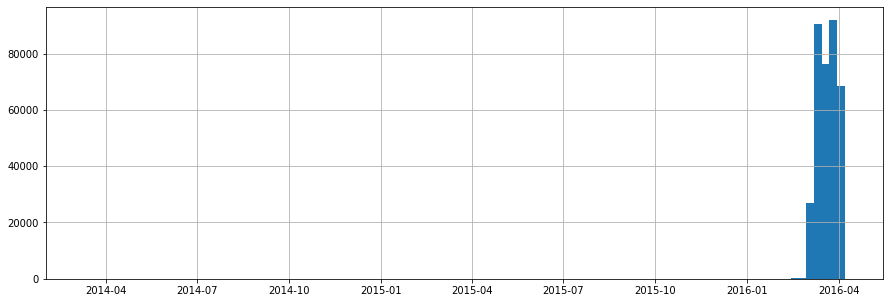

postal_code


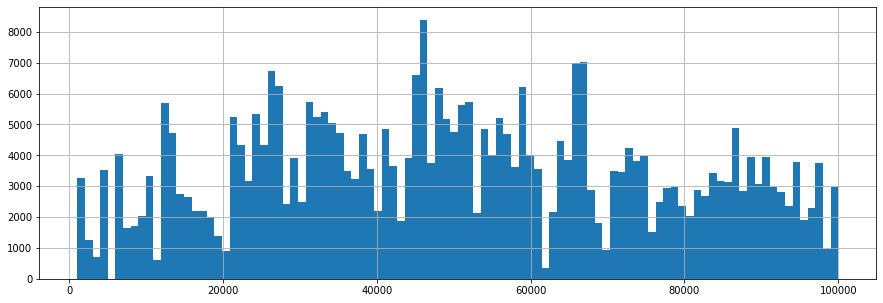

last_seen


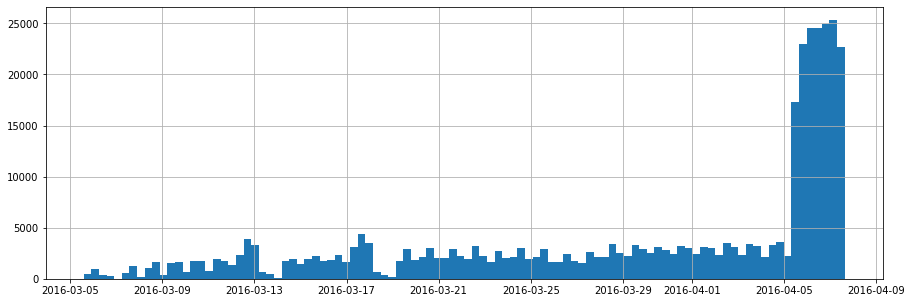

In [5]:
display(df.describe(datetime_is_numeric=True))
try:
    display(df.describe(include = ['object','bool']))
    for i in df.select_dtypes(include=['object','bool']):
        print('-----')
        if df[i].count() != len(df[i].unique()):
            print(df[i].value_counts())
        else:
            print('Все значения уникальны')
except:
    print('Все данные представлены в числовом формате')
print('-----')
for i in df:     
    if not ((df[i].dtype == 'object') & (len(df[i].unique()) > 100)):
        if len(df[i].unique()) > 1:
            print(i)
            if (len(df[i].unique()) < 100):
                # time.sleep(1)
                if df[i].dtype == 'object':
                    df[i].hist(bins=np.linspace(- 0.5, len(df[i].unique()) - 0.5, num=len(df[i].unique()) + 1), figsize=(15,5)) 
                else:
                    df[i].hist(bins=np.linspace(df[i].min() - 0.5 * (df[i].max() - df[i].min()) / (len(df[i].unique()) - 1), df[i].max() - df[i].min() + 0.5 * (df[i].max() - df[i].min()) / (len(df[i].unique()) - 1), num=len(df[i].unique()) + 1), figsize=(15,5))
                if (len(df[i].unique()) > 20):
                    plt.xticks(rotation=90)  
                plt.show() 
            else:        
                df[i].hist(bins=100, range=[df[i].min(), df[i].max()], figsize=(15,5))
                plt.show()

<font color='DarkBlue'> 
📌 По представленным графикам можно сделать следующие выводы: 
 
- стоимость основной массы автомобилей в объявлениях не превышает 3000    
- в большинстве объявлений автомобили с ручной коробкой передач, бензиновыми двигатели (gasoline и petrol) и пробегом около 150000 км
- самая популярная марка продаваемых автомобилей - volkswagen  
- даты создания анкет и скачивания их из базы привязаны к марту и апрелю 2016 года, даты последней активности пользователя - к апрелю 2016 года
- заметно, что значения признаков года регистрации и мощности имеют аномалии, необходимо рассмотреть разброс значений более подробно
- много записей без обозначения модели продаваемого автомобиля. Так как этот признак является одним из самых основных параметров для определения предсказаний в дальнейшем и отсутствует возможность его адекватного определения по остальным признакам, строки с пропущенными значениями можно удалить
- следует заменить следующие пропущенные и аномальные значения признаков самыми частыми или усредненными в зависимости от их типа, группируя выборки по модели и марке автомобилей: 'gearbox', 'registration_year', 'vehicle_type', 'fuel_type', 'power'    
- большинство авто в объявлениях являются битыми, есть также объекты с неуказанным значением, которое предпочтительнее заменить на наиболее часто встречающееся во всей выборке, поскольку отсутствует взаимосвязь данного параметра по отношению к другим
- требуется удалить следующие неинформативные признаки: месяц регистрации автомобиля (присутствуют нулевые значения), почтовый индекс пользователей, количество изображений (все объявления соглачно исходным данным не имеют изображений), все обозначения дат. При использовании датасета в качестве выборки для машинного обучения эти столбцы удаляются, так как в них не содержатся информативные данные, по которым можно упорядочить записи или провести аналогии и взаимосвязи с другими признаками
- коррелирующие признаки в соответствии с рассматриваемым типом объектов отсутствуют
- присутствует большая вероятность того, что модель покажет достаточно достоверную стоимость, т.к. заметно выделяюся значения соответствующего целевого признака через каждые 500 единиц
- объекты в исходной выборке вероятно получены из общей с применением нескольких фильтров, например, объявления относительно автомобилей стоимостью не более 20000 евро и пробегом не более 150000

📌 Также можно определить, присутствуют ли зависимости между пропущенными значениями в разных столбцах, например для признака, определяющего вид коробки передач, как имеющего меньшее количество пропусков, что позволит установить взаимосвязи с большей вероятностью, и остальных признаков
</font>     
 
Предсказать - vehicle_type, gearbox (усредн), model (-), fuel_type, после зануления - registration_year (усредн), power (-)
Аномалии - registration_year (nan), power (nan)    
Заменить - not_repaired (+)
Удалить (+) - postal_code, registration_month, number_of_pictures (все по 0), (date_crawled, date_created - совпадают даты в большинстве, нужно удалить, цены за малое количество времени не изменились, данные не упорядочены по дате, last_seen тоже удалить)     

In [6]:
df[df['gearbox'].isna()]            

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354284,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354301,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354325,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354334,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


<font color='DarkBlue'> 
📌 Зависимостей не наблюдается, причиной пропусков скорее является техническая ошибка, так как их количество, составляющее около десятой части всех записей, достаточно большое. Удалять такое количество данных не желательно, корректно заменить на среднее или наиболее часто встречающееся значение столбца с распределением по подгруппам. Многие поля является определяющими для обнаружения целевого признака <br>
📌 Необходимо удалить обозначенные ранее неинформатифные признаки <br>    
</font> 

In [7]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
df = df[df['model'] != 'other'].dropna(subset=['model'])
df.shape

(310240, 10)

<font color='DarkBlue'> 
📌 Теперь можно привести идентичные по значению параметры признаков, касающиеся вида топлива, к общему наименованию <br> 
</font> 

In [8]:
print('Количество значений вида топлива типа \'gasoline\' до преобразования:', df[df['fuel_type'] == 'gasoline']['brand'].count())
print('Количество значений вида топлива типа \'petrol\' до преобразования:', df[df['fuel_type'] == 'petrol']['brand'].count())

Количество значений вида топлива типа 'gasoline' до преобразования: 90020
Количество значений вида топлива типа 'petrol' до преобразования: 191370


In [9]:
# df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

In [10]:
print('Количество значений вида топлива типа \'gasoline\' после преобразования:', df[df['fuel_type'] == 'gasoline']['brand'].count())
print('Количество значений вида топлива типа \'petrol\' после преобразования:', df[df['fuel_type'] == 'petrol']['brand'].count())

Количество значений вида топлива типа 'gasoline' после преобразования: 0
Количество значений вида топлива типа 'petrol' после преобразования: 281390


<font color='DarkBlue'> 
📌 Нужно рассмотреть в первом приближении распределение стоимости автомобилей в объявлениях для определения возможных аномалий <br> 
</font> 

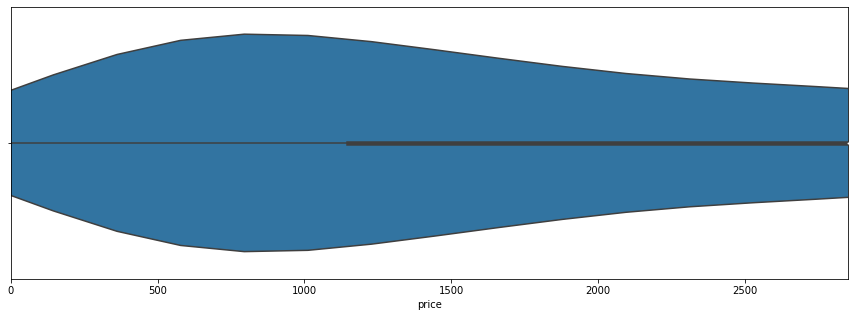

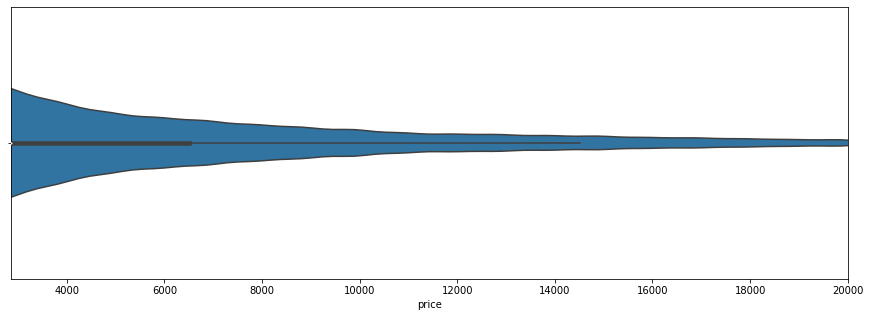

In [11]:
plt.figure(figsize = (15,5))
sns.violinplot(data=df, x='price', scale='count')
plt.xlim(df['price'].min(),df['price'].quantile(0.5))
plt.show()
plt.figure(figsize = (15,5))
sns.violinplot(data=df, x='price', scale='count')
plt.xlim(df['price'].quantile(0.5),df['price'].max())
plt.show()

<font color='DarkBlue'> 
📌 Как можно определить из графиков, сомнительными является значения, близкие к нулевым <br> 
</font> 

In [12]:
display(df[df['price'] == 0])
print('1 процентиль:', df['price'].quantile(0.01)) 
print('2 процентиль:', df['price'].quantile(0.02))
print('3 процентиль:', df['price'].quantile(0.03))
print('4 процентиль:', df['price'].quantile(0.04))
print('5 процентиль:', df['price'].quantile(0.05))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
231,0,wagon,2001,manual,115,mondeo,150000,NaN,ford,NaN
334,0,NaN,2005,NaN,0,polo,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354201,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


1 процентиль: 0.0
2 процентиль: 0.0
3 процентиль: 60.0
4 процентиль: 160.0
5 процентиль: 250.0


<font color='DarkBlue'> 
📌 Можно обозначить значения, соответствующим наименьшим 3 процентилям выборки, как NaN для корректного их определения в дальнейшем и использования соответствующих объектов в качестве тестовой выборки. Также можно определить количество обозначенных записей с использованием поля, не имеющего пропусков и аномалий <br> 
</font> 

In [13]:
df.loc[df['price'] <= 50, 'price'] = np.NaN
print('Количество элементов в тестовой выборке:', df.loc[df['price'].isna(), 'brand'].count())

Количество элементов в тестовой выборке: 9277


<font color='DarkBlue'> 
📌 Необходимо заменить аномальные значения на NaN поля 'registration_year' для их последующего преобразования, определить их количество и для определения достоверности результата выполненной операции построить гистограмму распределения <br> 
</font> 

Количество отсутствующих значений в поле 'registration_year': 78


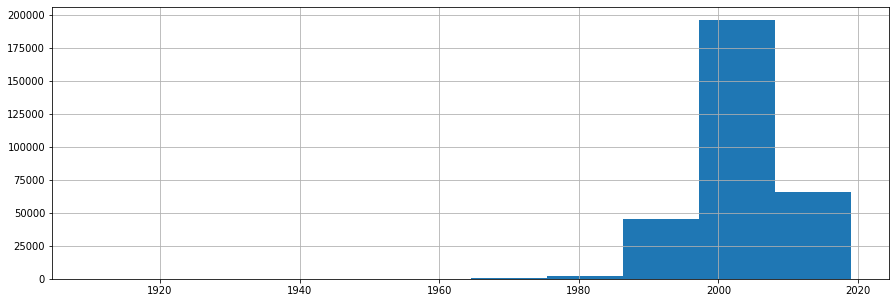

In [14]:
df.loc[(df['registration_year'] < 1900) | (df['registration_year'] > 2022), 'registration_year'] = np.NaN
print('Количество отсутствующих значений в поле \'registration_year\':', df[df['registration_year'].isna()]['brand'].count())
df['registration_year'].hist(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Значения, указанные на графике соответствуют действительно возможным значениям <br> 
📌 Далее необходимо рассмотреть аномальные значения поля 'power' <br>     
</font> 

In [15]:
df.sort_values('power')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480.0,NaN,1993.0,manual,0,golf,150000,petrol,volkswagen,NaN
266610,3500.0,wagon,2004.0,manual,0,megane,150000,petrol,renault,no
166816,950.0,small,1999.0,NaN,0,focus,150000,petrol,ford,NaN
266628,449.0,NaN,2016.0,NaN,0,ka,150000,NaN,ford,NaN
166808,3000.0,NaN,1990.0,NaN,0,80,5000,NaN,audi,NaN
...,...,...,...,...,...,...,...,...,...,...
63986,3250.0,sedan,2001.0,auto,17932,omega,150000,petrol,opel,NaN
132485,2100.0,wagon,2001.0,manual,19208,5er,150000,NaN,bmw,yes
114106,9999.0,sedan,2006.0,manual,19211,1er,125000,petrol,bmw,NaN
299177,1500.0,wagon,1997.0,manual,19312,5er,150000,NaN,bmw,no


<font color='DarkBlue'> 
📌 Необходимо обезличить аномальные значения рассматриваемого поля и построить гистограмму для анализа результатов <br> 
📌 Далее необходимо рассмотреть аномальные значения поля 'power' <br>     
</font> 

Количество отсутствующих значений в поле 'power': 30861


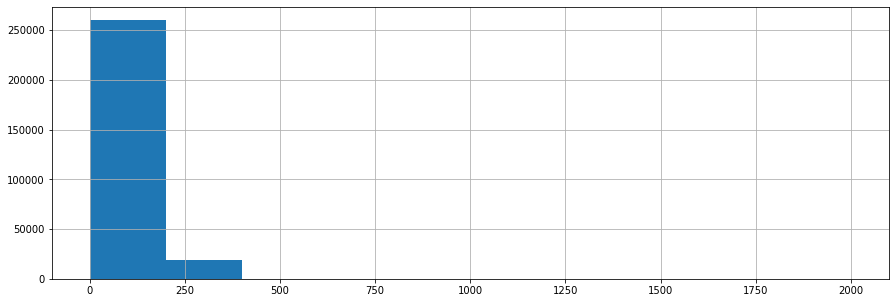

In [16]:
df.loc[(df['power'] == 0) | (df['power'] > 2000), 'power'] = np.NaN
print('Количество отсутствующих значений в поле \'power\':', df[df['power'].isna()]['brand'].count())
df['power'].hist(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Для полноценной интерпретации результатов можно построить более детальные графики <br> 
</font> 

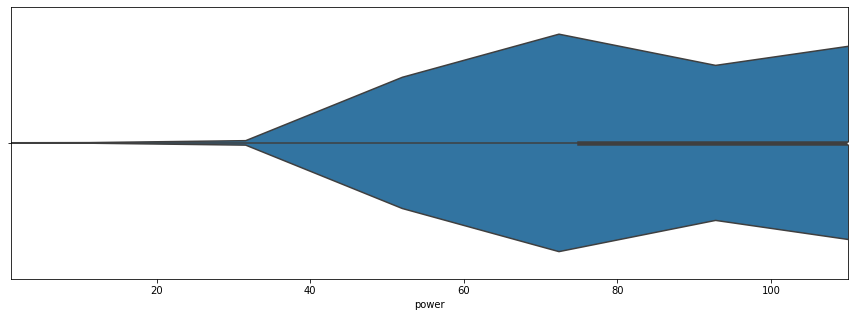

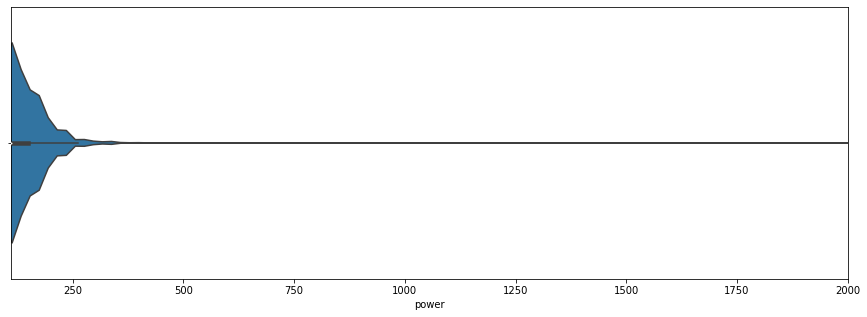

In [17]:
plt.figure(figsize = (15,5))
sns.violinplot(data=df, x='power', scale='count')
plt.xlim(df['power'].min(),df['power'].quantile(0.5))
plt.show()
plt.figure(figsize = (15,5))
sns.violinplot(data=df, x='power', scale='count')
plt.xlim(df['power'].quantile(0.5),df['power'].max())
plt.show()

<font color='DarkBlue'> 
📌 Теперь можно выделить явные граница и заменить выделяющиеся значения на NaN <br> 
</font> 

Количество отсутствующих значений в поле 'power': 33898


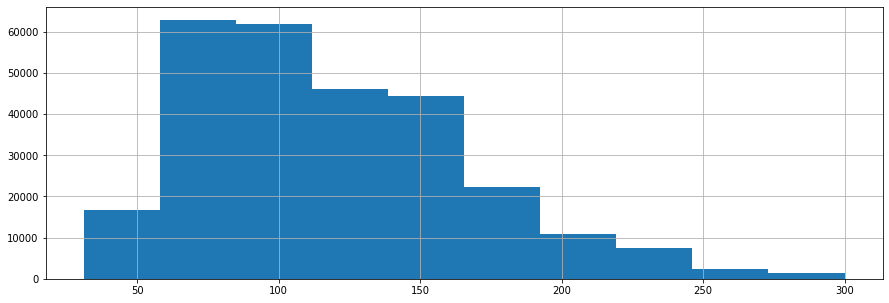

In [18]:
df.loc[(df['power'] <= 30) | (df['power'] > 300), 'power'] = np.NaN
print('Количество отсутствующих значений в поле \'power\':', df[df['power'].isna()]['brand'].count())
df['power'].hist(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 В соответствии с обозначенными ранее выводами, оптимальным решением является необходимость заменить пропуски в поле 'not_repaired' на наиболее часто встречающееся значение <br> 
</font> 

In [19]:
df.loc[df['not_repaired'].isna(), 'not_repaired'] = df['not_repaired'].value_counts().index[0]

<font color='DarkBlue'> 
📌 Далее нужно заполнить отсутствующие значения полей 'gearbox', 'registration_year', 'vehicle_type', 'fuel_type', 'power' наиболее часто встречающимися или усредненными в соответствии с маркой автомобиля <br> 
📌 Можно представить сгруппированную таблицу в соответствующем виде <br>     
</font> 

In [20]:
df.groupby(['brand','model']).count()

price  vehicle_type  registration_year  gearbox  power  \
brand      model                                                              
alfa_romeo 145          45            35                 49       40     38   
           147         561           492                572      549    532   
           156         594           581                627      601    571   
           159         208           200                212      209    202   
           spider      188           181                194      176    170   
...                    ...           ...                ...      ...    ...   
volvo      v40         743           707                775      750    676   
           v50         252           244                255      252    247   
           v60          42            41                 42       40     40   
           v70         617           609                633      610    586   
           xc_reihe    266           260                267      259    256   

                     kilometer  fuel_type  not_repaired  
brand      model                                         
alfa_romeo 145              49         44            49  
           147             572        541           572  
           156             629        570           629  
           159             212        198           212  
           spider          194        180           194  
...                        ...        ...           ...  
volvo      v40             775        694           775  
           v50             255        245           255  
           v60              42         41            42  
           v70             633        591           633  
           xc_reihe        267        261           267  

[258 rows x 8 columns]

<font color='DarkBlue'> 
📌 Для информации можно указать количество пропущенных значений для каждого из участвующих далее в обучении моделей признаков <br> 
</font> 

In [21]:
for i in ['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type']:
    print(i)
    print(df[df[i].isna()]['brand'].count())

vehicle_type
28803
registration_year
78
gearbox
14306
power
33898
fuel_type
23773


<font color='DarkBlue'> 
📌 Необходимо заменить рассматриваемые значения усредненными или наиболее часто встречающимися значениями для соответствующих моделей авто <br> 
</font> 

In [22]:
for i in ['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type']:
    if df[i].dtype == 'object':
        df[i] = df[i].where(~df[i].isna(), df.groupby(['brand','model'])[i].transform(lambda x: x.value_counts().index[0]))
    else:
        df[i] = round(df[i].where(~df[i].isna(), df.groupby(['brand','model'])[i].transform('mean')))

<font color='DarkBlue'> 
📌 Для достоверности полученного результата можно снова указать количество пропущенных значений рассматриваемых признаков <br> 
</font> 

In [23]:
for i in ['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type']:
    print(i)
    print(df[df[i].isna()]['brand'].count())

vehicle_type
0
registration_year
0
gearbox
0
power
2
fuel_type
0


<font color='DarkBlue'> 
📌 Нужно удалть строки со значениями, которые не удалось заменить действительным по причине их отсутствия для соответствующей марки автомобиля <br> 
</font> 

In [24]:
df[df['power'].isna()]
df = df.dropna(subset=['power'])
print('Количество отсутствующих значений:', df[df['power'].isna()]['brand'].count())
df.shape

Количество отсутствующих значений: 0


(310238, 10)

<font color='DarkBlue'> 
📌 Далее необходимо выполнить преобразование типов данных, если отсутствует необходимость в осуществлении арифметических операций между значениями датасета <br>
</font> 

In [25]:
df['power'] = df['power'].astype('int')
df['registration_year'] = df['registration_year'].astype('int')

In [26]:
df[df.select_dtypes(include=['int']).columns] = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[df.select_dtypes(include=['float']).columns] = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310238 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              300962 non-null  float32
 1   vehicle_type       310238 non-null  object 
 2   registration_year  310238 non-null  uint16 
 3   gearbox            310238 non-null  object 
 4   power              310238 non-null  uint16 
 5   model              310238 non-null  object 
 6   kilometer          310238 non-null  uint32 
 7   fuel_type          310238 non-null  object 
 8   brand              310238 non-null  object 
 9   not_repaired       310238 non-null  object 
dtypes: float32(1), object(6), uint16(2), uint32(1)
memory usage: 20.1+ MB


## Обучение моделей

<font color='DarkBlue'> 
📌 Первоначально необходимо разделить полученную после преобразований выборку на основную, которую в дальнейшем необходимо будет использовать в качестве обучающей и валидационной, и тестовую, не имеющую значения целевого признака <br> 
</font> 

In [27]:
df_train = df[~df['price'].isna()]
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300962 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              300962 non-null  float32
 1   vehicle_type       300962 non-null  object 
 2   registration_year  300962 non-null  uint16 
 3   gearbox            300962 non-null  object 
 4   power              300962 non-null  uint16 
 5   model              300962 non-null  object 
 6   kilometer          300962 non-null  uint32 
 7   fuel_type          300962 non-null  object 
 8   brand              300962 non-null  object 
 9   not_repaired       300962 non-null  object 
dtypes: float32(1), object(6), uint16(2), uint32(1)
memory usage: 19.5+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480.0,sedan,1993,manual,104,golf,150000,petrol,volkswagen,no
2,9800.0,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500.0,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650.0,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [28]:
df_test = df[df['price'].isna()]
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9276 entries, 40 to 354360
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              0 non-null      float32
 1   vehicle_type       9276 non-null   object 
 2   registration_year  9276 non-null   uint16 
 3   gearbox            9276 non-null   object 
 4   power              9276 non-null   uint16 
 5   model              9276 non-null   object 
 6   kilometer          9276 non-null   uint32 
 7   fuel_type          9276 non-null   object 
 8   brand              9276 non-null   object 
 9   not_repaired       9276 non-null   object 
dtypes: float32(1), object(6), uint16(2), uint32(1)
memory usage: 616.0+ KB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
40,NaN,small,1990,manual,67,corsa,150000,petrol,opel,no
89,NaN,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
111,NaN,sedan,2017,manual,104,golf,5000,petrol,volkswagen,no
152,NaN,bus,2004,manual,101,meriva,150000,lpg,opel,yes
231,NaN,wagon,2001,manual,115,mondeo,150000,petrol,ford,no


<font color='DarkBlue'> 
📌 Теперь требуется определить наилучшие гиперпараметры по наименьшенму RMSE для следующих алгоритмов машинного обучения: LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor. Также необходимо проверить модели на адекватность (R2 должно быть больше 0) и переобучение <br> 
📌 Для обучения модели с использованием алгоритма LinearRegression необходимо выполнить OHE кодирование и масштабирование количественных признаков, разбиение на обучающую и валидационную выборку рекомендуется стандартно выполнить в пропорции 3 к 1 <br> 
</font> 

In [29]:
df_ohe = pd.get_dummies(df_train, drop_first=True)
df_features = df_ohe.drop(['price'], axis=1)
df_target = df_ohe['price']
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features, df_target, test_size=0.25, random_state=12345)

In [30]:
numeric = df_features_train.select_dtypes(include=['uint16', 'uint32', 'float32']).columns
scaler = StandardScaler()
scaler.fit(df_features_train[numeric]) 
df_features_train[numeric] = scaler.transform(df_features_train[numeric])
df_features_valid[numeric] = scaler.transform(df_features_valid[numeric])

In [31]:
%%time
model = LinearRegression(n_jobs=-1)  
model.fit(df_features_train, df_target_train)

CPU times: user 14.3 s, sys: 4.54 s, total: 18.9 s
Wall time: 18.9 s


LinearRegression(n_jobs=-1)

R2 модели на обучающей выборке: 0.6447841234951792
R2 модели на валидационной выборке: 0.6480508364725741
RMSE модели на валидационной выборке: 2676.9372925945213
MAE модели на валидационной выборке: 1882.6312528242581
Среднее значение предсказания: 4641.327080232188


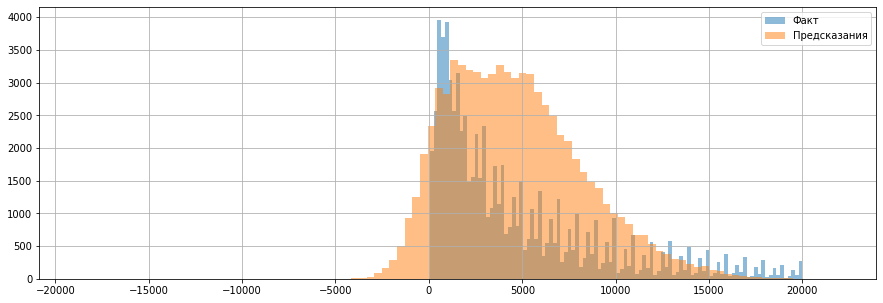

In [32]:
df_predicted_valid = model.predict(df_features_valid)
print('R2 модели на обучающей выборке:', model.score(df_features_train, df_target_train))
print('R2 модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
print('RMSE модели на валидационной выборке:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели на валидационной выборке:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 На основе отображенной информации можно обозначить следующие выводы:  
    
- время обучения модели достаточно малое, следует учесть, что не осуществлялся перебор по гиперпараметрам,
- модель не переобучена, так как коэффициенты детерминации на обучающей и валидационной выборках соотносимы и близки по значению,
- коэффициент детерминации не достаточно высокий, но больше 0, соответстственно проверка модели на адекватность пройдена,
- гистограммы визуально очень сильно различаются, заментна большая разница между фактическими значениями и предсказанными, для более подробного анализа необходимо изучить результаты обучения модели по исходной выборке другими алгоритмами
    
📌 Для обучения модели с использованием алгоритма RandomForestRegressor необходимо выполнить OE кодирование. Предполагается замена тренировочных и валидационных выборок без создания новых переменных для соответствующего типа кодирования в целях оптимизации производительности выполнения вычислительных процессов в тетради <br> 
</font> 

In [33]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df_train), columns=df_train.columns)
df_features = df_ordinal.drop('price', axis=1)
df_target = df_train['price']
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features, df_target, test_size=0.25, random_state=12345)

In [34]:
%%time
model = RandomForestRegressor(n_jobs=-1)
parameters = {'n_estimators': range (31, 51, 10), 'max_depth': range (5, 11)}
grid = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, random_state=12345, cv=3)
grid.fit(df_features_train, df_target_train)
print('Лучшая модель:', grid.best_estimator_)
print('Параметры лучшей модели:', grid.best_params_)  
print('Лучшая метрика RMSE:', abs(grid.best_score_) ** 0.5)  
model.fit(df_features_train, df_target_train)

Лучшая модель: RandomForestRegressor(max_depth=10, n_estimators=41, n_jobs=-1)
Параметры лучшей модели: {'n_estimators': 41, 'max_depth': 10}
Лучшая метрика RMSE: 1867.6014524264172
CPU times: user 3min 36s, sys: 691 ms, total: 3min 36s
Wall time: 3min 37s


RandomForestRegressor(n_jobs=-1)

R2 модели на обучающей выборке: 0.9469886777240636
R2 модели на валидационной выборке: 0.8775975444734301
RMSE модели на валидационной выборке: 1578.6770461844926
MAE модели на валидационной выборке: 957.5785223921608
Среднее значение предсказания: 4658.44261902081


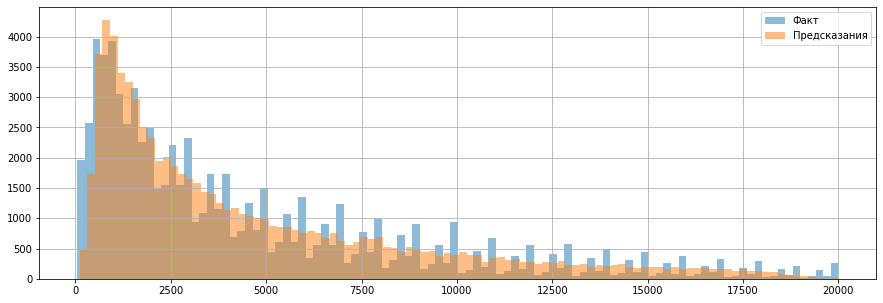

In [35]:
df_predicted_valid = model.predict(df_features_valid)
print('R2 модели на обучающей выборке:', model.score(df_features_train, df_target_train))
print('R2 модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
print('RMSE модели на валидационной выборке:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели на валидационной выборке:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 На основе указанной информации можно обозначить следующие выводы:  
    
- время обучения модели не малое, так как осуществлялся подбор наилучших гиперпараметров для обучения модели,
- качество модели хорошее, но следует учесть, что метрики усреднены после выполнения перекрестного обучения
- модель скорее переобучена, так как коэффициент детерминации по предсказаниям на обучающей выборке заметно больше, чем на валидационной
- гистограммы визуально похожи по распределениям, но отсутствуют предсказания со значением стоимости около граничного, модель 'перестраховывается', полагая, что выход значений за определенную границу соответствует аномальным. Для уменьшения фактора сглаживания значений целевого признака можно снизить величину параметра 'max_depth'
    
📌 Для обучения модели с использованием алгоритма LGBMRegressor также необходимо использовать выборки, полученные после преобразования методом OE кодирования, так как алгоритм построен на функционале предыдущего. Алгоритм самостоятельно осуществляет масштабирование численных признаков <br> 
</font> 

In [36]:
%%time
model = LGBMRegressor(n_estimators=50, n_jobs=-1)
parameters = {'max_depth': range (5, 11), 'num_leaves': range (31, 51, 10)}
# 'boosting_type': ['gbdt', 'rf', 'dart', 'goss']
# 'learning_rate': 0.03
grid = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, random_state=12345, cv=3)
grid.fit(df_features_train, df_target_train)
print('Лучшая модель:', grid.best_estimator_)
print('Параметры лучшей модели:', grid.best_params_)  
print('Лучшая метрика RMSE:', abs(grid.best_score_) ** 0.5)   
model = grid.best_estimator_
model.fit(df_features_train, df_target_train)

Лучшая модель: LGBMRegressor(max_depth=10, n_estimators=50, num_leaves=41)
Параметры лучшей модели: {'num_leaves': 41, 'max_depth': 10}
Лучшая метрика RMSE: 1769.3063878516734
CPU times: user 8min 3s, sys: 2.87 s, total: 8min 6s
Wall time: 8min 10s


LGBMRegressor(max_depth=10, n_estimators=50, num_leaves=41)

R2 модели на обучающей выборке: 0.849957386326362
R2 модели на валидационной выборке: 0.8505031058764352
RMSE модели на валидационной выборке: 1744.6741013914252
MAE модели на валидационной выборке: 1122.7694861011885
Среднее значение предсказания: 4637.535894785118


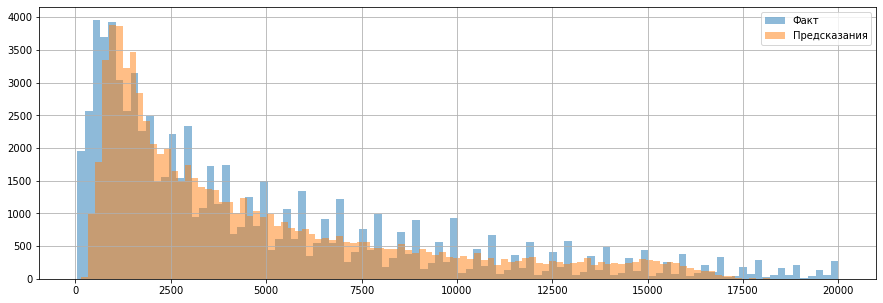

In [37]:
df_predicted_valid = model.predict(df_features_valid)
print('R2 модели на обучающей выборке:', model.score(df_features_train, df_target_train))
print('R2 модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
print('RMSE модели на валидационной выборке:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели на валидационной выборке:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 На основе представленной информации можно обозначить следующие выводы:  
    
- время обучения модели больше, чем у остальных, так как возможно использовалось больше вариантов наборов гиперпараметров для обучения модели или более значимых,
- качество модели достаточно хорошее, немного меньше, чем после обучения модели предыдущим алгоритмом,
- модель не переобучена согласно указанным метрикам для обучающей и валидационной выборок
- гистограммы визуально похожи по распределениям, но отсутствуют предсказания со значением стоимости более 17000 согласно концепции, указанной в предыдущих выводах
    
📌 Для обучения модели с использованием алгоритма CatBoostRegressor требуется использовать выборки без их преобразования, но с указанием категориальных. Алгоритм перед обучением модели самостоятельно осуществляет кодирование и масштабирование признаков <br> 
</font> 

In [38]:
%%time
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_train.drop('price', axis=1), df_train.price, test_size=0.25, random_state=12345)
cat_features = ['gearbox', 'vehicle_type', 'model', 'fuel_type','brand', 'not_repaired']
model = CatBoostRegressor(iterations=50, loss_function='RMSE')
parameters = {'depth': range (5, 11), 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}
# 'bootstrap_type': ['Bayesian', 'MVS', 'Poisson', 'No']
# 'boosting_type': ['Ordered', 'Plain']
# 'learning_rate': 0.03
grid = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, random_state=12345, cv=3)
grid.fit(df_features_train, df_target_train, cat_features=cat_features, verbose=0)
print('Лучшая модель:', grid.best_estimator_)
print('Параметры лучшей модели:', grid.best_params_)  
print('Лучшая метрика RMSE:', abs(grid.best_score_) ** 0.5)   
model = grid.best_estimator_
model.fit(df_features_train, df_target_train, cat_features=cat_features, verbose=0)

Лучшая модель: <catboost.core.CatBoostRegressor object at 0x7fa5ab2271c0>
Параметры лучшей модели: {'grow_policy': 'Depthwise', 'depth': 8}
Лучшая метрика RMSE: 1650.4430673262639
CPU times: user 2min 34s, sys: 1.35 s, total: 2min 35s
Wall time: 3min 14s


R2 модели на обучающей выборке: 0.8857315939512003
R2 модели на валидационной выборке: 0.869896050268228
RMSE модели на валидационной выборке: 1627.5841823471824
MAE модели на валидационной выборке: 1027.9404797374298
Среднее значение предсказания: 4648.554165751449


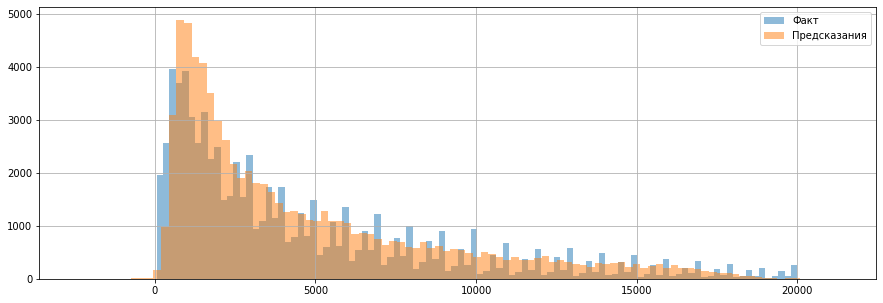

In [39]:
df_predicted_valid = model.predict(df_features_valid)
print('R2 модели на обучающей выборке:', model.score(df_features_train, df_target_train))
print('R2 модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
print('RMSE модели на валидационной выборке:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели на валидационной выборке:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 На основе представленной информации можно обозначить следующие выводы:  
    
- время обучения модели заметно меньше, чем у предыдущей, так как возможно использовалось меньшее количество вариантов различного набора гиперпараметров для обучения модели или менее значимых,
- качество модели хорошее, метрики похожи на полученные после обучения модели предыдущим алгоритмом
- модель не переобучена согласно указанным метрикам для обучающей и валидационной выборок
- графики визуально похожи по распределениям, гистограмма предсказаний целевого признака распределена на полном интервале его фактических значений, но присутствует большее количество наиболее часто встречающихся значений
    
📌 Все обученные модели являются адекватными, но алгоритм LinearRegression показывает заметно худшие результаты обучения согласно представленным метрикам и сравнения гистограмм распределения. Его использование в финальном определении лучшего алгоритма в соответствии с предпочтительными гиперпараметрами не является необходимым  <br> 
</font> 

## Анализ моделей

<font color='DarkBlue'> 
📌 В первичном рассмотрении в соответствии со сравнением гистограмм распределения и отсутствием фактора переобучения LightGBM подходит больше, поэтому сначала рекомендуется рассмотреть результаты остальных алгоритмов
📌 Для удобного представления и сравнения желательно создать таблицу с сохранением параметров обученных моделей и важных для заказчика критериев <br> 
</font> 

In [58]:
table = pd.DataFrame(columns = ['name','R2','RMSE','MAE','mean','t_train','t_predict'])

<font color='DarkBlue'> 
📌 Следует обучить модель с использованием алгоритма CatBoostRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [59]:
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_train.drop('price', axis=1), df_train.price, test_size=0.25, random_state=12345)
cat_features = ['gearbox', 'vehicle_type', 'model', 'fuel_type','brand', 'not_repaired']

In [60]:
start_time = time.time()
model = CatBoostRegressor(iterations=50, loss_function='RMSE', grow_policy='Depthwise', depth=8)
model.fit(df_features_train, df_target_train, cat_features=cat_features, verbose=0)
t_train = round((time.time() - start_time) * 1000)
print(t_train, 'ms')

8997 ms


In [61]:
start_time = time.time()
df_predicted_valid = model.predict(df_features_valid)
t_predict = round((time.time() - start_time) * 1000)
print(t_predict, 'ms')

183 ms


R2 модели: 0.869896050268228
RMSE модели: 1627.5841823471824
MAE модели: 1027.9404797374298
Среднее значение предсказания: 4648.554165751449


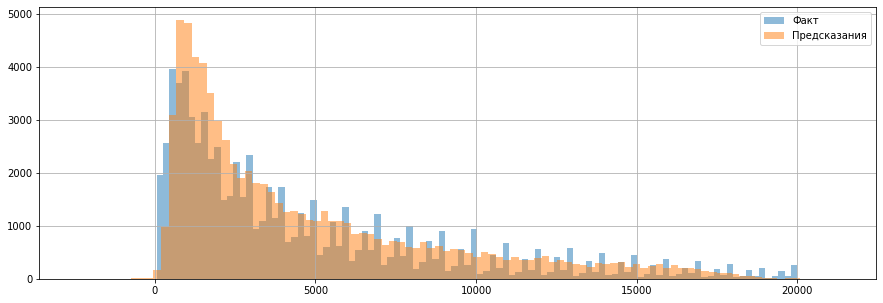

In [62]:
print('R2 модели:', model.score(df_features_valid, df_target_valid))
print('RMSE модели:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()
table = table.append({'name': 'CatBoostRegressor', 'R2': model.score(df_features_valid, df_target_valid), 'RMSE': mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5, 'MAE': mean_absolute_error(df_target_valid, df_predicted_valid), 'mean': df_predicted_valid.mean(), 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Ранее обозначенные выводы для модели соответствуют полученным результатам
📌 Для обучения модели следующими алгоритмами необходимо реализовать OE кодирование основных признаков
📌 Далее нужно обучить модель с использованием алгоритма RandomForestRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [63]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df_train), columns=df_train.columns)
df_features = df_ordinal.drop('price', axis=1)
df_target = df_train['price']
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features, df_target, test_size=0.25, random_state=12345)

In [64]:
start_time = time.time()
model = RandomForestRegressor(n_jobs=-1, n_estimators=41, max_depth=10)
model.fit(df_features_train, df_target_train)
t_train = round((time.time() - start_time) * 1000)
print(t_train, 'ms')

10929 ms


In [65]:
start_time = time.time()
df_predicted_valid = model.predict(df_features_valid)
t_predict = round((time.time() - start_time) * 1000)
print(t_predict, 'ms')

281 ms


R2 модели: 0.8313007901927102
RMSE модели: 1853.338524975058
MAE модели: 1202.1937290833296
Среднее значение предсказания: 4637.487390691102


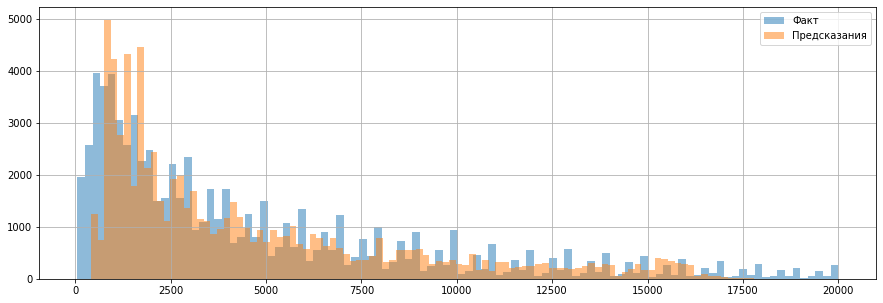

In [66]:
print('R2 модели:', model.score(df_features_valid, df_target_valid))
print('RMSE модели:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()
table = table.append({'name': 'RandomForestRegressor', 'R2': model.score(df_features_valid, df_target_valid), 'RMSE': mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5, 'MAE': mean_absolute_error(df_target_valid, df_predicted_valid), 'mean': df_predicted_valid.mean(), 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Метрики определяют худший результат по отношению к параметрам предыдущей модели, на гистограмме заметны периодически выбивающиеся интервалы наиболее частых значений целевого признака <br>
📌 Далее нужно обучить модель с использованием алгоритма LGBMRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [67]:
start_time = time.time()
model = LGBMRegressor(n_estimators=50, n_jobs=-1, num_leaves=41, max_depth=10)
model.fit(df_features_train, df_target_train)
t_train = round((time.time() - start_time) * 1000)
print(t_train, 'ms')

3034 ms


In [68]:
start_time = time.time()
df_predicted_valid = model.predict(df_features_valid)
t_predict = round((time.time() - start_time) * 1000)
print(t_predict, 'ms')

303 ms


R2 модели: 0.8505031058764352
RMSE модели: 1744.6741013914252
MAE модели: 1122.7694861011885
Среднее значение предсказания: 4637.535894785118


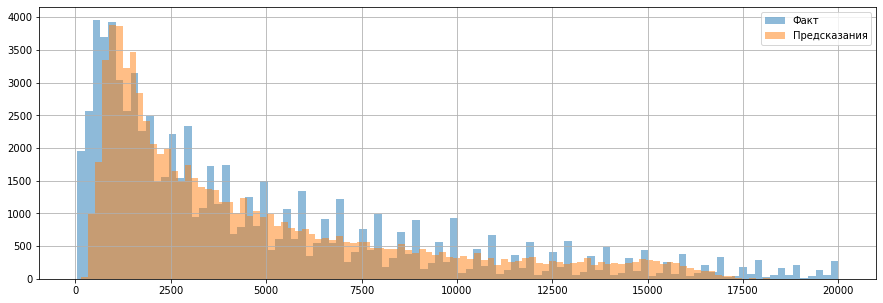

In [69]:
print('R2 модели:', model.score(df_features_valid, df_target_valid))
print('RMSE модели:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
print('MAE модели:', mean_absolute_error(df_target_valid, df_predicted_valid))
print('Среднее значение предсказания:', df_predicted_valid.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_valid).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()
table = table.append({'name': 'LGBMRegressor', 'R2': model.score(df_features_valid, df_target_valid), 'RMSE': mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5, 'MAE': mean_absolute_error(df_target_valid, df_predicted_valid), 'mean': df_predicted_valid.mean(), 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Ранее обозначенные выводы для модели соответствуют полученным результатам, но скорость выполнения операций заметно выше, чем при переборе гиперпараметров
📌 Теперь можно вывести на экран таблицу для анализа параметров моделей <br> 
</font> 

In [70]:
table

,name,R2,RMSE,MAE,mean,t_train,t_predict
0,CatBoostRegressor,0.869896,1627.584182,1027.940480,4648.554166,8997,183
1,RandomForestRegressor,0.831301,1853.338525,1202.193729,4637.487391,10929,281
2,LGBMRegressor,0.850503,1744.674101,1122.769486,4637.535895,3034,303


<font color='DarkBlue'> 
📌 Исходя из указанных данных можно обозначить следующие выводы:
    
- модель CatBoostRegressor имеет лучшее качество предсказания согласно отображаемым метрикам и меньшее время предсказания, чем определяется удобство пользования моделью, но согласно ранее представленной гистограмме модель больше необходимого предсказывает частые значения
- модель RandomForestRegressor скорее имеет худшее качество предсказания, большое время обучени модели, что может являться критичным фактором для ввода в production, время предсказания имеет среднее значение среди представленных алгоритмов, при выборе данного алгоритма необходимо будет избавиться от фактора переобучения и сгладить график перебором гиперпараметров
- модель LGBMRegressor имеет среднее качество предсказания среди указанных в таблице алгоритмов и меньшее время обучения, что значительно облегчает также реализацию процесса переобучения модели, гистограммы фактических значений и предсказаний наиболее точно соответствуют на общем интервале значений, но скорость предсказания значительно меньше, чем у модели CatBoostRegressor <br>
    
📌 Время предсказания имеет меньший приоритет, чем время обучения, так как оно очень мало и в более низкой степени влияет на удобство пользования, соответственно, в данном контексте качество имеет наибольший вес, затем скорость обучения модели и предсказания. Исходя из того, что у модели LGBMRegressor согласно метрикам модели, полученной на валидационной выборке, качетсво приблизительно такое, как у модели CatBoostRegressor, но гистограмма распределена заметно более равномерно, и скорость обучения значительно ниже, чем у других моделей, выбор ее использования в данном проекте является наиболее подходящим <br> 
📌 Требуется определить значения целевого признака на выявленной тестовой выборке. Сначала необходимо осуществить OE кодирование для признаков используемого датасета. Также можно определить время выполнения предсказания и отобразить гистограммы распределения фактических значений целевого признака валидационной выборки и предсказанных <br> 
</font> 

In [71]:
encoder = OrdinalEncoder()
df_features_test = pd.DataFrame(encoder.fit_transform(df_test.drop('price', axis=1)), columns=df_test.drop('price', axis=1).columns)

In [72]:
%%time
df_predicted_test = model.predict(df_features_test)

CPU times: user 71.3 ms, sys: 0 ns, total: 71.3 ms
Wall time: 39.4 ms


Среднее значение предсказания: 2794.8331832771682


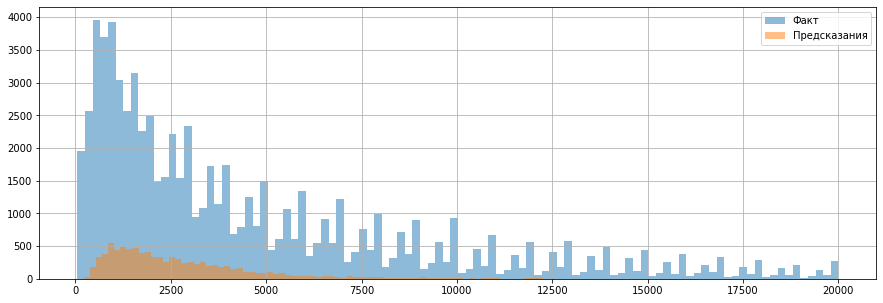

In [73]:
print('Среднее значение предсказания:', df_predicted_test.mean())
pd.Series(df_target_valid).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_test).hist(bins=100, label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 Согласно графику показания целевого признака распределены в похожем соотношении по всему интервалу <br> 
📌 Можно более детально подобрать наилучшие гиперпараметры для выбранной модели и при необходимости использовать в рабочем пространстве заказчика <br> 
</font> 

<font color='DarkBlue'> 
📌 На основании произведенных исследований можно сформировать следующие выводы:
- предоставленные данные посредственного качества, заголовки не представлены в общепринятом для аналитиков формате, содержится несколько дубликатов, некоторое количество пропусков и аномалий во многих полях, присутсвуют как технические ошибки в корректности данных, например, аномальных значений для года регистрации и мощности автомобилей, их отсутствии, например, количества изображений для каждого объекта, и обязательности заполнения полей, обозначающих тип кузова, модель и вид коробки передач, так и связанные с явлением человеческого фактора, например, отличающиеся наименования для одного типа топлива, отсуствие данных по наличию ДТП, где в случае добавления битого автомобиля как объекта пользователи не указывают данный факт,
- для более удобного использования необходимо преобразование типов данных в форматы, занимающие меньший объем памяти и заполнение пропусков некоторых столбцов усредненными или наиболее часто встречающимися значениями для соответствующих моделей авто,
- определено, что наилучшим алгоритмом обучения модели для определения стоимости автомобилей по исходным данным будет являться LGBMRegressor в соответствии с указанными выше обоснованиями после представленной таблицы и проверено качество на тестовой выборке. Наиболее важные критерии, послужившие основой для выбора модели, представлены в порядке убывания: качество предсказания, время обучения модели, время предсказания модели
- значение ключевой метрики RMSE согласно анализу предсказаний определения стоимости автомобилей на валидационных выборке моделей, выбранных для финального сравнения, меньше 2500
    
📌 Вопрос для ревьювера: какие гиперпараметры для моделей, основанных на градиентном бустинге, используются чаще всего и в каких интервалах и вариантах подлежат перебору и имеют наилучшее качество
</font> 